In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import DataLoader, Dataset
import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt

import os
import librosa
from torchmetrics.audio import SignalDistortionRatio
import torchsummary

In [5]:
# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=8, out_channels=4, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [8]:
torchsummary.summary(Autoencoder(), (1, 100000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1           [-1, 16, 100000]              64
              ReLU-2           [-1, 16, 100000]               0
            Conv1d-3            [-1, 8, 100000]             392
              ReLU-4            [-1, 8, 100000]               0
            Conv1d-5            [-1, 4, 100000]             100
              ReLU-6            [-1, 4, 100000]               0
   ConvTranspose1d-7            [-1, 8, 100000]             104
              ReLU-8            [-1, 8, 100000]               0
   ConvTranspose1d-9           [-1, 16, 100000]             400
             ReLU-10           [-1, 16, 100000]               0
  ConvTranspose1d-11            [-1, 1, 100000]              49
             Tanh-12            [-1, 1, 100000]               0
Total params: 1,109
Trainable params: 1,109
Non-trainable params: 0
-----------------------------------

In [52]:

# Define custom dataset
class SpeechDataset(Dataset):
    def __init__(self, noisy_waveforms, clean_waveforms):

        noisy_waveforms = [torch.tensor(np.pad(noisy_waveform.numpy()[:, :100_000], ((0, 0), (0, 100_000 - len(noisy_waveform[0]))))) for noisy_waveform in noisy_waveforms]
        clean_waveforms = [torch.tensor(np.pad(clean_waveform.numpy()[:, :100_000], ((0, 0), (0, 100_000 - len(clean_waveform[0]))))) for clean_waveform in clean_waveforms]

        # self.noisy_waveforms = torch.stack(noisy_waveforms, dim=0)
        # self.clean_waveforms = torch.stack(clean_waveforms, dim=0)

        self.noisy_waveforms = torch.tensor(noisy_waveforms)
        self.clean_waveforms = torch.tensor(clean_waveforms)

    def __len__(self):
        return len(self.noisy_waveforms)

    def __getitem__(self, idx):
        try:
            return torch.Tensor(self.noisy_waveforms[idx]), torch.Tensor(self.clean_waveforms[idx])
        
        except RuntimeError:
            print('Error in index:', idx)
            return torch.Tensor(self.noisy_waveforms[0]), torch.Tensor(self.clean_waveforms[0])


In [3]:
def load_dataset(path):
    data = []

    for i in tqdm(os.listdir(path)):
        waveform, sample_rate = torchaudio.load(os.path.join(path, i), frame_offset=20_000, num_frames=100_000)
        data.append(waveform)

    return data

In [4]:
noisy_train = load_dataset('../data/uk/noisy_trainset_28spk_wav')

100%|██████████| 11572/11572 [00:15<00:00, 769.22it/s]


In [9]:
clean_train = load_dataset('../data/uk/clean_trainset_28spk_wav')

100%|██████████| 11572/11572 [00:21<00:00, 540.76it/s] 


In [59]:
model = Autoencoder().to("mps")
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 40
losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for data in tqdm(train_loader):
        noisy, clean = data
        noisy = noisy.to("mps")
        clean = clean.to("mps")
        optimizer.zero_grad()
        outputs = model(noisy)
        loss = criterion(outputs, clean)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    losses.append(running_loss/len(train_loader))
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

100%|██████████| 2893/2893 [01:41<00:00, 28.53it/s]


Epoch 1/40, Loss: 0.00990864572225823


100%|██████████| 2893/2893 [01:36<00:00, 29.84it/s]


Epoch 2/40, Loss: 0.0019242838709883172


100%|██████████| 2893/2893 [01:43<00:00, 27.89it/s]


Epoch 3/40, Loss: 0.006313508956744943


100%|██████████| 2893/2893 [01:48<00:00, 26.57it/s]


Epoch 4/40, Loss: 0.016517865507878916


100%|██████████| 2893/2893 [01:45<00:00, 27.32it/s]


Epoch 5/40, Loss: 0.017044118898503824


100%|██████████| 2893/2893 [01:36<00:00, 29.96it/s]


Epoch 6/40, Loss: 0.005509382807236001


100%|██████████| 2893/2893 [02:02<00:00, 23.61it/s]


Epoch 7/40, Loss: 0.005262453854760053


100%|██████████| 2893/2893 [02:11<00:00, 21.93it/s]


Epoch 8/40, Loss: 0.0051363244512872665


100%|██████████| 2893/2893 [02:05<00:00, 22.97it/s]


Epoch 9/40, Loss: 0.005022281254978121


100%|██████████| 2893/2893 [01:50<00:00, 26.10it/s]


Epoch 10/40, Loss: 0.004967266847992769


100%|██████████| 2893/2893 [01:57<00:00, 24.71it/s]


Epoch 11/40, Loss: 0.0049443783881088004


100%|██████████| 2893/2893 [01:40<00:00, 28.74it/s]


Epoch 12/40, Loss: 0.004926289104556518


100%|██████████| 2893/2893 [01:37<00:00, 29.78it/s]


Epoch 13/40, Loss: 0.004920401012703951


100%|██████████| 2893/2893 [01:41<00:00, 28.39it/s]


Epoch 14/40, Loss: 0.004918319011632465


100%|██████████| 2893/2893 [01:58<00:00, 24.51it/s]


Epoch 15/40, Loss: 0.004922167954116871


100%|██████████| 2893/2893 [02:09<00:00, 22.34it/s]


Epoch 16/40, Loss: 0.00492716559277821


100%|██████████| 2893/2893 [02:12<00:00, 21.86it/s]


Epoch 17/40, Loss: 0.00493743986237731


100%|██████████| 2893/2893 [02:09<00:00, 22.36it/s]


Epoch 18/40, Loss: 0.0049694481933044545


100%|██████████| 2893/2893 [02:15<00:00, 21.32it/s]


Epoch 19/40, Loss: 0.00498421544420304


100%|██████████| 2893/2893 [02:10<00:00, 22.13it/s]


Epoch 20/40, Loss: 0.005077286032448606


100%|██████████| 2893/2893 [01:55<00:00, 24.98it/s]


Epoch 21/40, Loss: 0.005179324563102706


100%|██████████| 2893/2893 [02:06<00:00, 22.92it/s]


Epoch 22/40, Loss: 0.005072557923184097


100%|██████████| 2893/2893 [02:02<00:00, 23.52it/s]


Epoch 23/40, Loss: 0.005000733987406036


100%|██████████| 2893/2893 [01:55<00:00, 25.11it/s]


Epoch 24/40, Loss: 0.004967221036531492


100%|██████████| 2893/2893 [01:56<00:00, 24.90it/s]


Epoch 25/40, Loss: 0.00496696068100809


100%|██████████| 2893/2893 [01:48<00:00, 26.68it/s]


Epoch 26/40, Loss: 0.004970714607302742


100%|██████████| 2893/2893 [02:03<00:00, 23.47it/s]


Epoch 27/40, Loss: 0.005183048562893262


100%|██████████| 2893/2893 [01:33<00:00, 30.91it/s]


Epoch 28/40, Loss: 0.006698003267973013


100%|██████████| 2893/2893 [01:31<00:00, 31.54it/s]


Epoch 29/40, Loss: 0.005570709294659809


100%|██████████| 2893/2893 [01:29<00:00, 32.24it/s]


Epoch 30/40, Loss: 0.005162701996753486


100%|██████████| 2893/2893 [01:29<00:00, 32.36it/s]


Epoch 31/40, Loss: 0.0050368199274304455


100%|██████████| 2893/2893 [01:29<00:00, 32.29it/s]


Epoch 32/40, Loss: 0.005044131870698628


100%|██████████| 2893/2893 [01:33<00:00, 31.01it/s]


Epoch 33/40, Loss: 0.0050947197437794375


100%|██████████| 2893/2893 [01:36<00:00, 29.84it/s]


Epoch 34/40, Loss: 0.005085678180570869


100%|██████████| 2893/2893 [01:38<00:00, 29.24it/s]


Epoch 35/40, Loss: 0.005135033681819385


100%|██████████| 2893/2893 [01:33<00:00, 31.07it/s]


Epoch 36/40, Loss: 0.005090669305487113


100%|██████████| 2893/2893 [01:31<00:00, 31.78it/s]


Epoch 37/40, Loss: 0.005166466295319318


100%|██████████| 2893/2893 [01:30<00:00, 31.85it/s]


Epoch 38/40, Loss: 0.005180093884642561


100%|██████████| 2893/2893 [01:45<00:00, 27.51it/s]


Epoch 39/40, Loss: 0.005156626136724976


100%|██████████| 2893/2893 [01:38<00:00, 29.47it/s]


Epoch 40/40, Loss: 0.005182311243454566


In [60]:
torch.save(model.state_dict(), '../models/autoencoder_40_20_120_0.0001.pth')

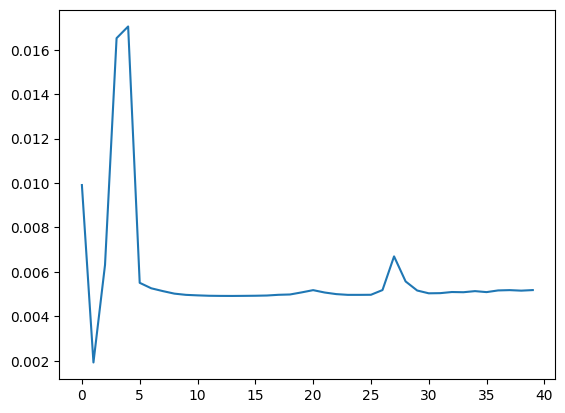

In [61]:
plt.plot(losses)

In [131]:

# Denoise a sample waveform
sample_noisy_waveform = noisy_train[0].unsqueeze(0).to("mps")  # Add batch and channel dimensions
denoised_waveform = model(sample_noisy_waveform)
SignalDistortionRatio()(denoised_waveform.to("cpu"), clean_train[0].unsqueeze(0).to("cpu"))

tensor(-3.9662, grad_fn=<SqueezeBackward0>)

In [140]:

# Denoise a sample waveform
sample_noisy_waveform = noisy_train[0].unsqueeze(0).to("mps")  # Add batch and channel dimensions
denoised_waveform = model(sample_noisy_waveform)
SignalDistortionRatio()(denoised_waveform.to("cpu"), clean_train[0].unsqueeze(0).to("cpu"))

tensor(-3.5517, grad_fn=<SqueezeBackward0>)

In [142]:

# Denoise a sample waveform
sample_noisy_waveform = noisy_train[0][:10000].unsqueeze(0).to("mps")  # Add batch and channel dimensions
denoised_waveform = model(sample_noisy_waveform)
SignalDistortionRatio()(denoised_waveform.to("cpu"), clean_train[0].unsqueeze(0).to("cpu"))

tensor(-3.5517, grad_fn=<SqueezeBackward0>)

In [70]:

# Denoise a sample waveform
sample_noisy_waveform = noisy_train[0].unsqueeze(0).to("mps")  # Add batch and channel dimensions
denoised_waveform = model(sample_noisy_waveform)
SignalDistortionRatio()(denoised_waveform.to("cpu"), clean_train[0].unsqueeze(0).to("cpu"))

tensor(-38.7761, grad_fn=<SqueezeBackward0>)

In [5]:
def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")

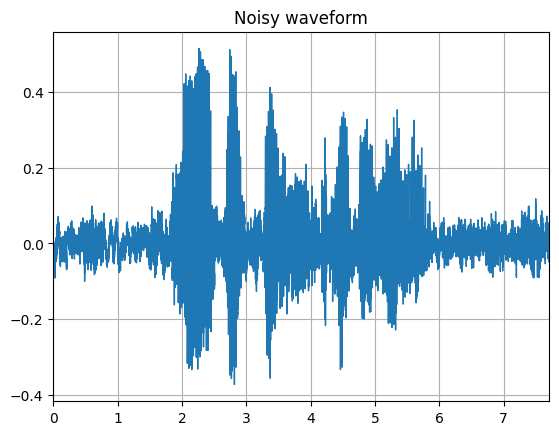

In [119]:
plot_waveform(noisy_train[0], 16000, title="Noisy waveform")

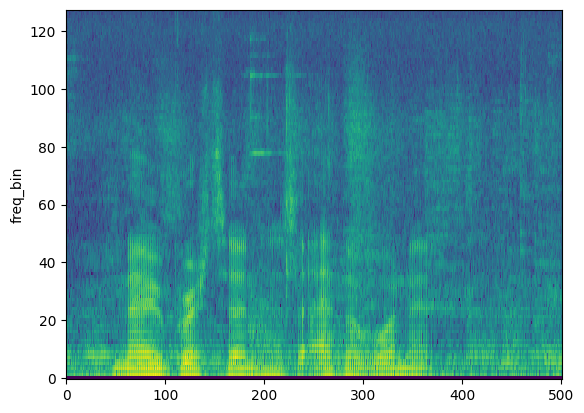

In [79]:
plot_spectrogram((torchaudio.transforms.MelSpectrogram(sample_rate=10000)(noisy_train[0]))[0])

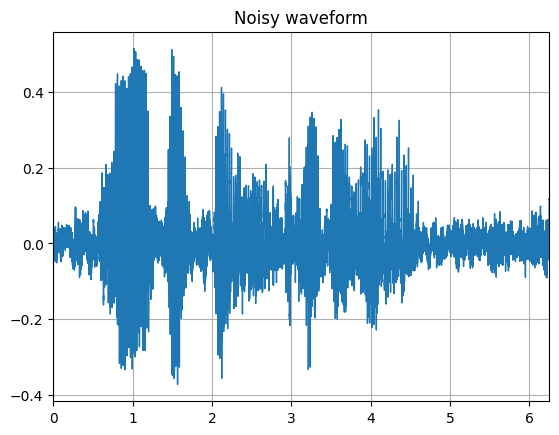

In [6]:
plot_waveform(noisy_train[0], 16000, title="Noisy waveform")

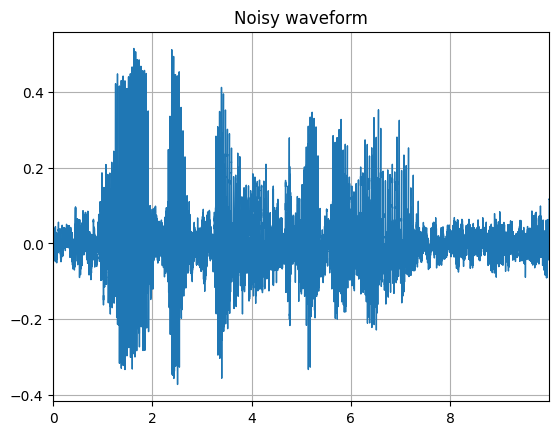

In [71]:
plot_waveform(noisy_train[0], 10000, title="Noisy waveform")

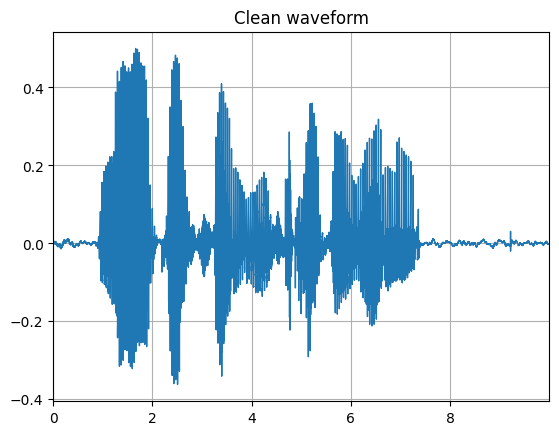

In [72]:
plot_waveform(clean_train[0], 10000, title="Clean waveform")

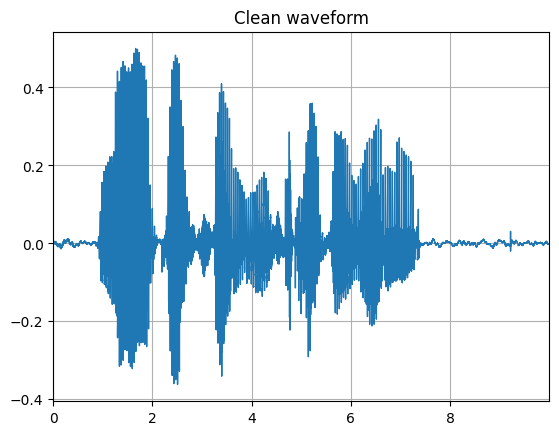

In [11]:
plot_waveform(clean_train[0], 10000, title="Clean waveform")

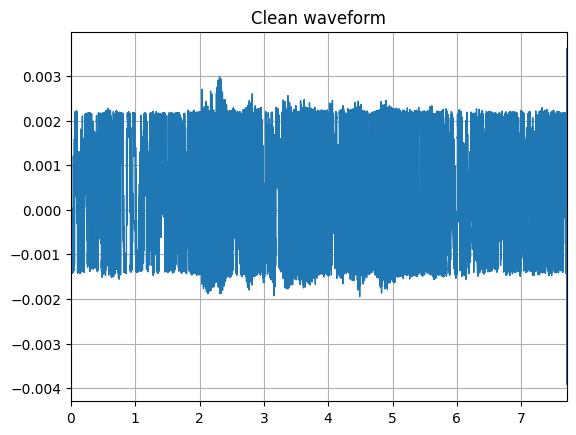

In [125]:
plot_waveform(denoised_waveform.squeeze(0).cpu().detach(), 16000, title="Clean waveform")

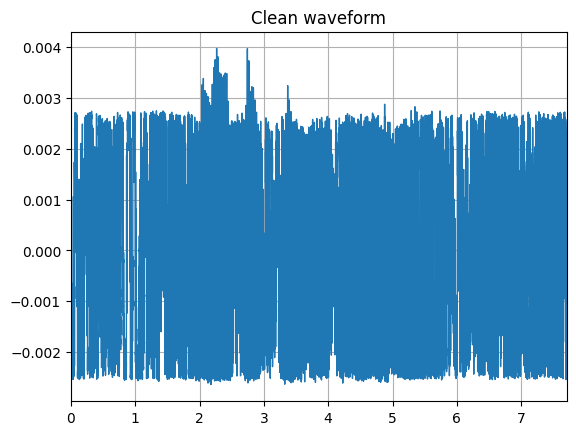

In [141]:
plot_waveform(denoised_waveform.squeeze(0).cpu().detach(), 16000, title="Clean waveform")

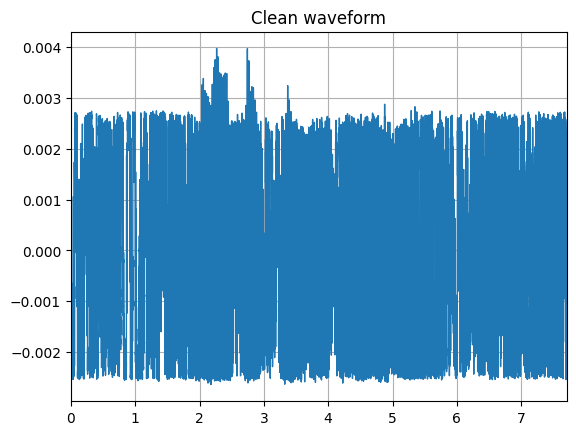

In [144]:
plot_waveform(denoised_waveform[:10000].squeeze(0).cpu().detach(), 16000, title="Clean waveform")

In [165]:
dist = np.zeros(int(4e5))

for i in tqdm(clean_train):
    try:
        dist += np.pad(i.squeeze().numpy(), (0, int(4e5) - len(i[0]))) / len(clean_train)

    except:
        pass

100%|██████████| 11572/11572 [00:06<00:00, 1666.08it/s]


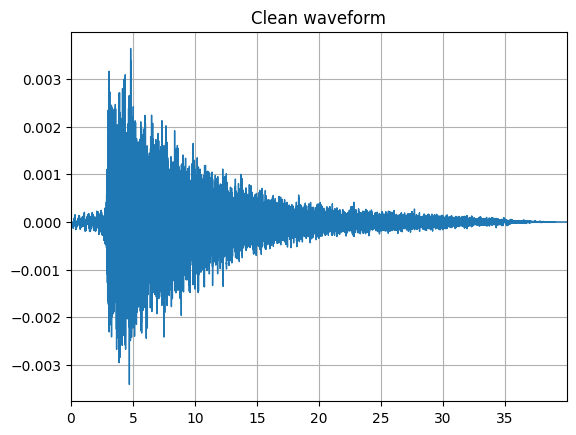

In [167]:
plot_waveform(torch.Tensor(dist).unsqueeze(0), 10000, title="Clean waveform")